# TF-MoDISco on the Nanog GkmExplain Scores, but without MEME init

Like the TF MoDISco Nanog notebook, but lacking the MEME cluster initialization step.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2021-03-07 15:44:06--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: ‘positives_test.fa.gz’

positives_test.fa.g 100%[===================>]  73.28K  --.-KB/s    in 0.08s   

2021-03-07 15:44:07 (916 KB/s) - ‘positives_test.fa.gz’ saved [75038/75038]

--2021-03-07 15:44:07--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

### Read in the one-hot encoded sequences and scores

In [3]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the
    # importance scores and hypothetical importance scores was
    # proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a
    # similar-in-spirit normalization that also appears to
    # improve the signal-to-noise ratio, but which is more
    # intuitive and better-motivated than the normalization
    # from the gkmexplain paper (the reason I didn't propose it
    # in that paper is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean
    # hypothetical importance across ACGT at each position such
    # that the sum of the hypothetical importance at each position
    # is 0. The intuition is that this highlights the impact of
    # each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance
    # is simply the normalized hypothetical importance multiplied
    # by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


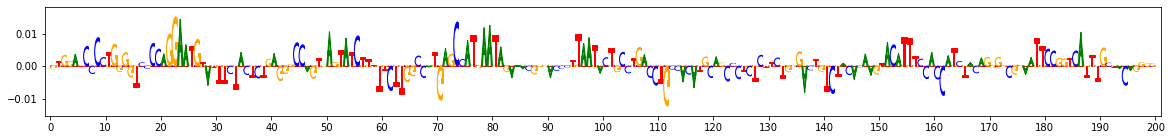

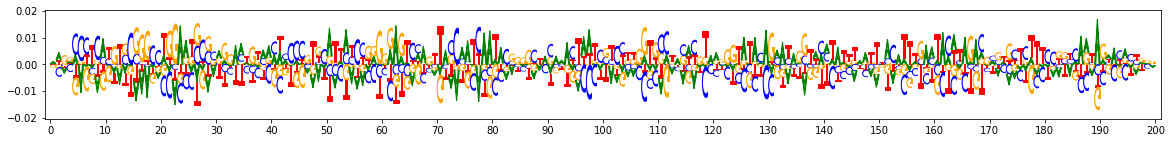

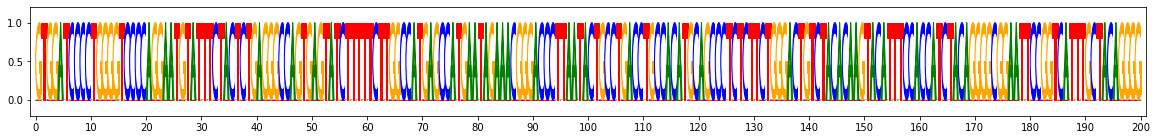

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

MEMORY 0.210034688
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold
For increasing = True , the minimum IR precision was 0.28762191141268867 occurring at 1.1961500000490233e-06 implying a frac_neg of 0.40374895862260485
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4829015187051677 occurring at -5.614999999965353e-07 implying a frac_neg of 0.9338676019623297
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.21752344639999993  and  0.15626441020500015 with frac passing 0.07338541666666666
Final raw thresholds are -0.21752344639999993  and  0.15626441020500015
Final transformed thresholds are -0.9723900462962963  and  0.9213773148148148


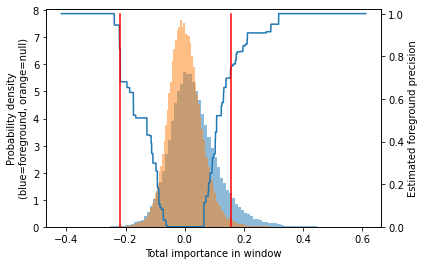

Got 923 coords
After resolving overlaps, got 923 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9212773148148148
MEMORY 0.288321536
923 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [903]
Idx to activities:  {0: '1'}
MEMORY 0.288366592
On metacluster 0
Metacluster size 903
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 903
(Round 1) Computing coarse affmat
MEMORY 0.288366592
2021-12-03 23:17:43.419053 Building the index
Fri Dec  3 23:17:43 2021 NN descent for 10 iterations


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	Stopping threshold met -- exiting after 4 iterations
2021-12-03 23:25:59.614827 Preparing the index
Fri Dec  3 23:26:35 2021 Forward diversification reduced edges from 27090 to 6387
Fri Dec  3 23:27:07 2021 Reverse diversification reduced edges from 6387 to 6387
Fri Dec  3 23:27:08 2021 Degree pruning reduced edges from 7816 to 7816
Fri Dec  3 23:27:08 2021 Resorting data and graph based on tree order
Fri Dec  3 23:27:08 2021 Compressing index by removing unneeded attributes
Fri Dec  3 23:27:08 2021 Building and compiling search function
2021-12-03 23:27:19.304006 Index ready
2021-12-03 23:27:19.304932 Querying neighbors for fwd
2021-12-03 23:30:18.982086 Querying neighbors for rev
2021-12-03 23:33:07.302410 Unifying fwd and rev
(Round 1) Computed coarse affmat
MEMORY 1.575727104
(Round 1) Computing density adapted affmat
MEMORY 1.575727104
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominato

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.7s


Quality: 0.19040972832716868
Got 3 clusters after round 1
Counts:
{0: 531, 1: 368, 2: 4}
MEMORY 1.893515264
(Round 1) Aggregating seqlets in each cluster
MEMORY 1.893515264
Aggregating for cluster 0 with 531 seqlets
MEMORY 1.893515264
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   11.4s finished


Skipped 8 seqlets that went over the sequence edge during flank expansion
Skipped 80 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 438
Skipped 44 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 368 seqlets
MEMORY 1.893572608
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 2 seqlets that went over the sequence edge during flank expansion
Skipped 44 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 320
Skipped 27 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 4 seqlets
MEMORY 1.893597184
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that were requ

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s


Quality: 0.1158735541520309
Got 5 clusters after round 2
Counts:
{0: 393, 1: 292, 4: 1, 2: 2, 3: 1}
MEMORY 2.882441216
(Round 2) Aggregating seqlets in each cluster
MEMORY 2.882441216
Aggregating for cluster 0 with 393 seqlets
MEMORY 2.882441216


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.4s finished


Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 4 seqlets that went over sequence edge during flank expansion
Skipped 5 due to duplicates
Trimming eliminated 0 seqlets out of 383
Skipped 24 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 292 seqlets
MEMORY 2.882609152
Skipped 1 seqlets that went over sequence edge during flank expansion
Skipped 2 due to duplicates
Trimming eliminated 0 seqlets out of 289
Skipped 16 seqlets that went over the sequence edge during flank expansion
Removed 1 duplicate seqlets
Aggregating for cluster 2 with 2 seqlets
MEMORY 2.882609152
Trimming eliminated 0 seqlets out of 2
Aggregating for cluster 3 with 1 seqlets
MEMORY 2.882609152
Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 4 with 1 seqlets
MEMORY 2.882609152
Trimming eliminated 0 seqlets out of 1
Got 5 clusters
Splitting into subclusters...
MEMORY 2.882609152
Inspecting pattern 0 for spurious merging


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 252 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 352 out of 359 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 359 out of 359 | elapsed:    0.2s finished


[t-SNE] Computed conditional probabilities for sample 359 / 359
[t-SNE] Mean sigma: 0.363619
Beginning preprocessing + Leiden
Affmat shape: 359


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s


Quality: 0.38693203572840096
Quality: 0.3959050584133901
Got subclusters: Counter({0: 144, 1: 128, 2: 47, 3: 37, 4: 3})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.4s finished


Numbers for each pattern pre-subsample: [144, 128, 47, 37, 3]
Numbers after subsampling: [144, 128, 47, 37, 3]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.4694828987121582 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.3592112064361572 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.17233991622924805 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.16725707054138184 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.05283403396606445 s
Cluster sizes
[144 128  47  37   3]
Cross-contamination matrix:
[[1.   0.5  0.66 0.36 0.34]
 [0.47 1.   0.56 0.26 0.38]
 [0.63 0.57 1.   0.33 0.35]
 [0.72 0.54 0.71 1.   0.35]
 [0.01 0.01 0.01 0.   1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.59 0.75 0.7  0.52]
 [0.59 1.   0.67 0.53 0.44]
 [0.75 0.67 1.   0.67 0.46]
 [0.7  0.53 0.67 1.   0.41]
 [0.52 0.44 0.46 0.41 1.  ]]
Inspecting pattern 1 for spurious merging


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 250 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 272 out of 272 | elapsed:    0.2s finished


[t-SNE] Computed conditional probabilities for sample 272 / 272
[t-SNE] Mean sigma: 0.330550
Beginning preprocessing + Leiden
Affmat shape: 272


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s


Quality: 0.209809247649681
Quality: 0.20998258915555218
Quality: 0.21052404587917822
Quality: 0.21206903198994675
Quality: 0.21323405745991356
Quality: 0.2146347888591932
Got subclusters: Counter({0: 50, 1: 49, 2: 49, 3: 37, 4: 37, 5: 21, 6: 15, 7: 12, 8: 2})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.3s finished


Numbers for each pattern pre-subsample: [50, 49, 49, 37, 37, 21, 15, 12, 2]
Numbers after subsampling: [50, 49, 49, 37, 37, 21, 15, 12, 2]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.2927570343017578 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.2669210433959961 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.27106165885925293 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.25557899475097656 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.25000500679016113 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.16254115104675293 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.14221477508544922 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.12293696403503418 s
Computing sims for pattern 8
Computed sims for pattern 8 in 0.05957508087158203 s
Cluster sizes
[50 49 49 37 37 21 15 12  2]
Cross-contamination matrix:
[[1.   0.97 0.54 0.52 0.76 0.36 0.39 0.43 0.4 ]
 [0.81

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 175 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 222 out of 222 | elapsed:    0.1s finished
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed alt

[t-SNE] Iteration 100: error = 64.7270432, gradient norm = 0.4741616 (50 iterations in 0.026s)
[t-SNE] Iteration 150: error = 67.8788300, gradient norm = 0.4165772 (50 iterations in 0.024s)
[t-SNE] Iteration 200: error = 64.8125305, gradient norm = 0.4438740 (50 iterations in 0.023s)
[t-SNE] Iteration 250: error = 66.3469543, gradient norm = 0.4831586 (50 iterations in 0.023s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.346954
[t-SNE] Iteration 300: error = 1.1321511, gradient norm = 0.0058118 (50 iterations in 0.023s)
[t-SNE] Iteration 350: error = 0.7820332, gradient norm = 0.0021079 (50 iterations in 0.022s)
[t-SNE] Iteration 400: error = 0.7789406, gradient norm = 0.0006290 (50 iterations in 0.021s)
[t-SNE] Iteration 450: error = 0.7778916, gradient norm = 0.0002639 (50 iterations in 0.023s)
[t-SNE] Iteration 500: error = 0.7764649, gradient norm = 0.0000900 (50 iterations in 0.023s)
[t-SNE] Iteration 550: error = 0.7765030, gradient norm = 0.0000677 (50 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s


Quality: 0.19925564283359248
Quality: 0.20023318472319493


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:    0.1s finished


Got subclusters: Counter({0: 44, 1: 42, 3: 37, 2: 37, 4: 28, 5: 26, 6: 8})
On pattern 1
[t-SNE] Computing 143 nearest neighbors...
[t-SNE] Indexed 144 samples in 0.001s...
[t-SNE] Computed neighbors for 144 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 144 / 144
[t-SNE] Mean sigma: 0.384751
[t-SNE] Computed conditional probabilities in 0.005s
[t-SNE] Iteration 50: error = 60.5267105, gradient norm = 0.5202800 (50 iterations in 0.016s)
[t-SNE] Iteration 100: error = 62.7300835, gradient norm = 0.5244116 (50 iterations in 0.016s)
[t-SNE] Iteration 150: error = 59.9222565, gradient norm = 0.4649183 (50 iterations in 0.022s)
[t-SNE] Iteration 200: error = 59.5262070, gradient norm = 0.5470375 (50 iterations in 0.016s)
[t-SNE] Iteration 250: error = 59.1947861, gradient norm = 0.5203605 (50 iterations in 0.016s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.194786
[t-SNE] Iteration 300: error = 0.8685390, gradient norm = 0.0099560 (50 it

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s


Quality: 0.19640541395026295
Quality: 0.19811809032881428
Quality: 0.20044432402026735


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 out of 128 | elapsed:    0.0s finished


Got subclusters: Counter({0: 45, 1: 34, 2: 27, 3: 20, 4: 18})
On pattern 2
[t-SNE] Computing 127 nearest neighbors...
[t-SNE] Indexed 128 samples in 0.001s...
[t-SNE] Computed neighbors for 128 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 0.420339
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 64.1060715, gradient norm = 0.4573981 (50 iterations in 0.019s)
[t-SNE] Iteration 100: error = 66.3742065, gradient norm = 0.4713542 (50 iterations in 0.015s)
[t-SNE] Iteration 150: error = 64.7026367, gradient norm = 0.4401650 (50 iterations in 0.015s)
[t-SNE] Iteration 200: error = 64.3829041, gradient norm = 0.4762014 (50 iterations in 0.015s)
[t-SNE] Iteration 250: error = 58.4604721, gradient norm = 0.5183086 (50 iterations in 0.015s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.460472
[t-SNE] Iteration 300: error = 0.7676870, gradient norm = 0.0079553 (50 iterations in 0

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s


Quality: 0.21707435879142065
Quality: 0.21717144576998548
Quality: 0.21737080112018584


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  47 out of  47 | elapsed:    0.0s finished


Got subclusters: Counter({0: 44, 1: 41, 2: 36, 3: 7})
On pattern 3
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 47 samples in 0.001s...
[t-SNE] Computed neighbors for 47 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 47 / 47
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 44.6532478, gradient norm = 0.6214333 (50 iterations in 0.009s)
[t-SNE] Iteration 100: error = 42.8034515, gradient norm = 0.6475692 (50 iterations in 0.010s)
[t-SNE] Iteration 150: error = 42.5904884, gradient norm = 0.3843959 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 48.3142090, gradient norm = 0.3988540 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 41.6154213, gradient norm = 0.5752616 (50 iterations in 0.009s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.615421
[t-SNE] Iteration 300: error = 0.7814292, gradient norm = 0.0012503 (50 iterations in

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s


Quality: 5.684341886081034e-14


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  37 out of  37 | elapsed:    0.0s finished


Got subclusters: Counter({0: 47})
On pattern 4
[t-SNE] Computing 36 nearest neighbors...
[t-SNE] Indexed 37 samples in 0.000s...
[t-SNE] Computed neighbors for 37 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 37 / 37
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 45.7724686, gradient norm = 0.5171661 (50 iterations in 0.009s)
[t-SNE] Iteration 100: error = 42.6852798, gradient norm = 0.6050647 (50 iterations in 0.008s)
[t-SNE] Iteration 150: error = 46.5239182, gradient norm = 0.4363622 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 42.9632645, gradient norm = 0.5383960 (50 iterations in 0.008s)
[t-SNE] Iteration 250: error = 45.0646133, gradient norm = 0.5156723 (50 iterations in 0.008s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.064613
[t-SNE] Iteration 300: error = 0.5669866, gradient norm = 0.0007566 (50 iterations in 0.008s)
[t-SNE] Ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s


Quality: 3.463895836830574e-14
Got subclusters: Counter({0: 37})
On pattern 5
[t-SNE] Computing 20 nearest neighbors...
[t-SNE] Indexed 21 samples in 0.001s...
[t-SNE] Computed neighbors for 21 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 21 / 21
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 48.0560837, gradient norm = 0.3865097 (50 iterations in 0.009s)
[t-SNE] Iteration 100: error = 47.6853333, gradient norm = 0.4990253 (50 iterations in 0.007s)
[t-SNE] Iteration 150: error = 44.5329285, gradient norm = 0.6750193 (50 iterations in 0.007s)
[t-SNE] Iteration 200: error = 44.3952332, gradient norm = 0.6440527 (50 iterations in 0.007s)
[t-SNE] Iteration 250: error = 42.6491470, gradient norm = 0.4963783 (50 iterations in 0.007s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.649147
[t-SNE] Iteration 300: error = 0.4813173, gradient norm = 0.0009006 (50 it

[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Affmat shape: 21


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s


Quality: 4.44089209850064e-16
Got subclusters: Counter({0: 21})


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.3s finished


In [5]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    final_min_cluster_size=20,
                    #setting use_pynnd_with_continjacc=True directly
                    # uses the continuous jaccard similarity (with pynndescent)
                    # in the so-called "coarse-grained" step, meaning there
                    # is no need for a separate fine-grained step. This can
                    # lead to improved results. However, pynndescent can be
                    # finicky (e.g. it can run into errors when run on google colab;
                    # see https://github.com/lmcinnes/pynndescent/issues/133)
                    use_pynnd_with_continjacc=True
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [6]:
import h5py
import modisco.util
reload(modisco.util)
! [[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


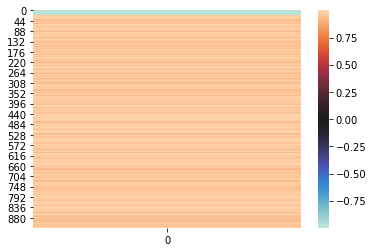

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 222
Hypothetical scores:


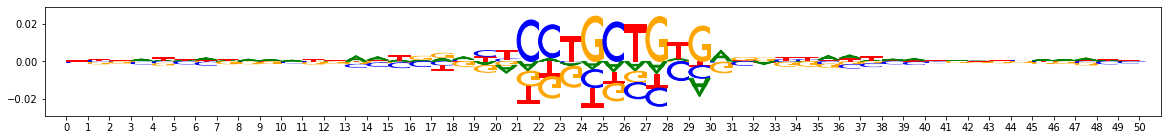

Actual importance scores:


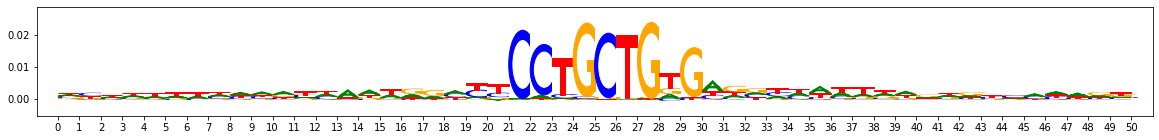

onehot, fwd and rev:


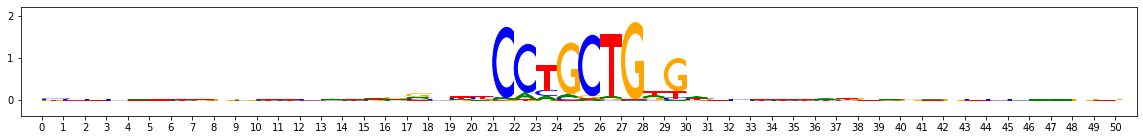

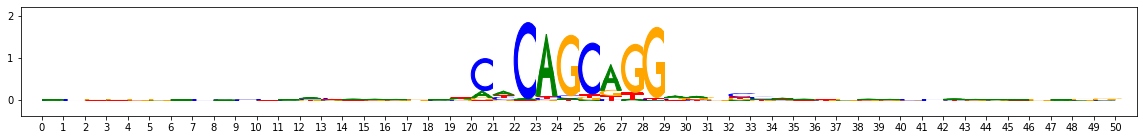

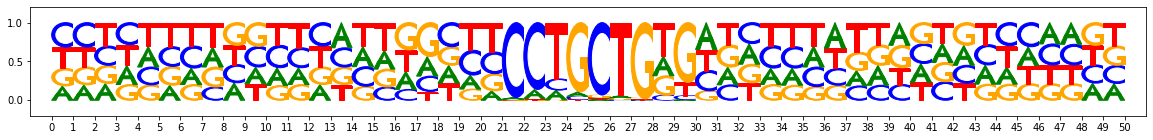

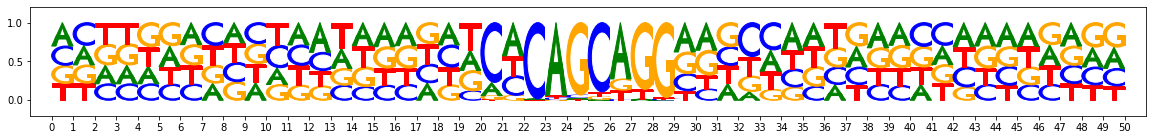

metacluster_0 pattern_1
total seqlets: 144
Hypothetical scores:


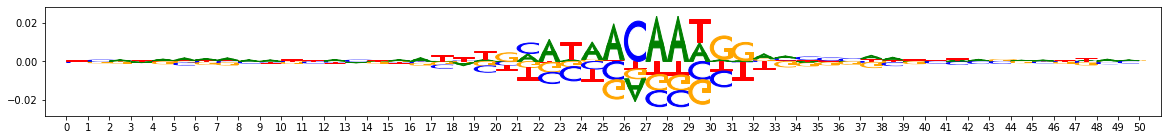

Actual importance scores:


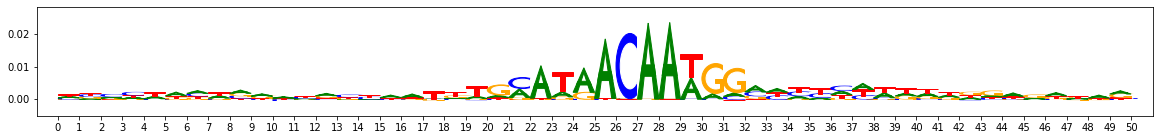

onehot, fwd and rev:


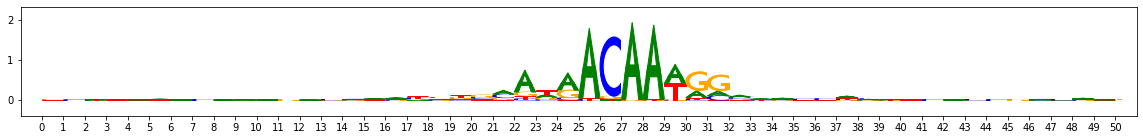

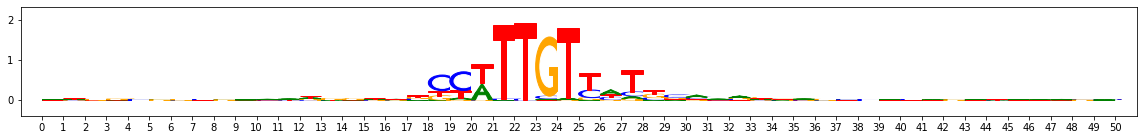

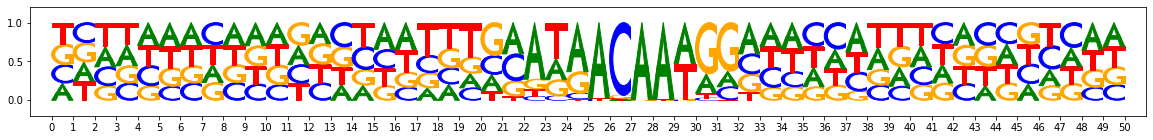

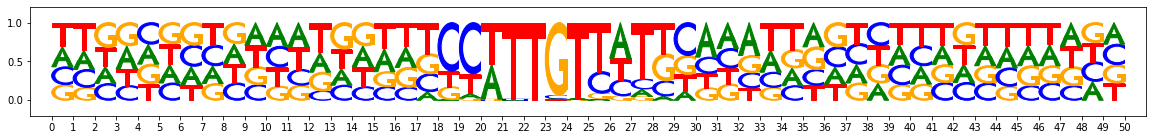

metacluster_0 pattern_2
total seqlets: 128
Hypothetical scores:


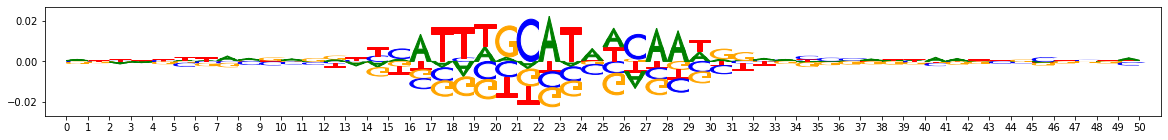

Actual importance scores:


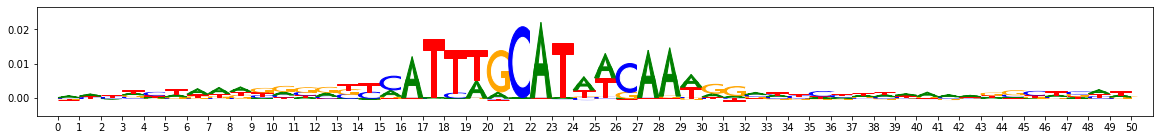

onehot, fwd and rev:


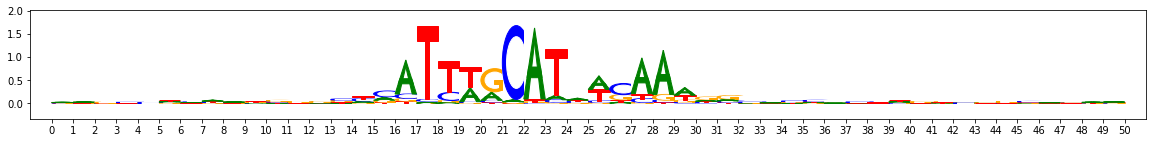

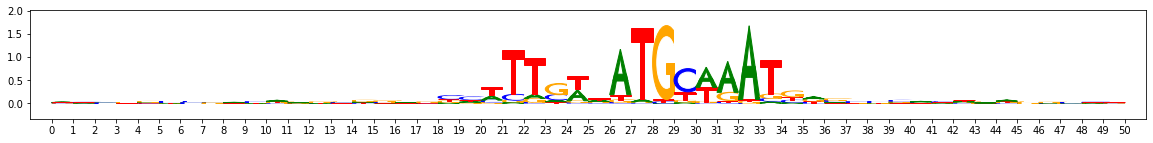

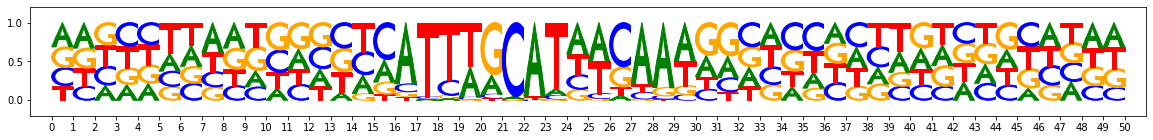

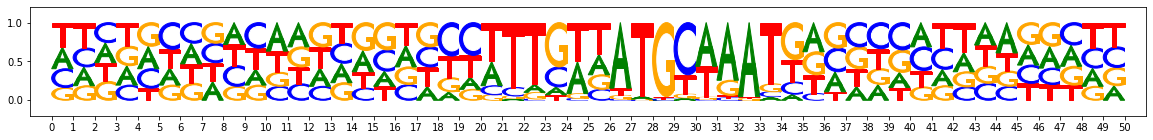

metacluster_0 pattern_3
total seqlets: 47
Hypothetical scores:


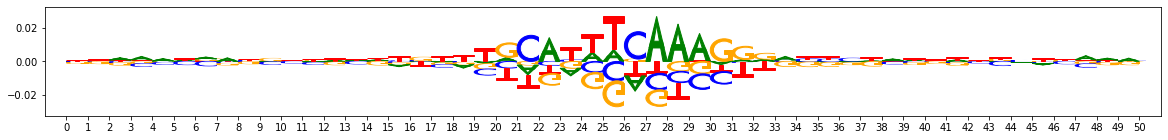

Actual importance scores:


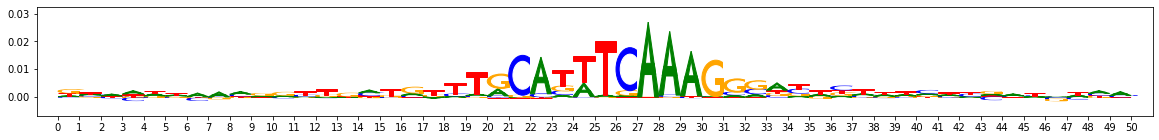

onehot, fwd and rev:


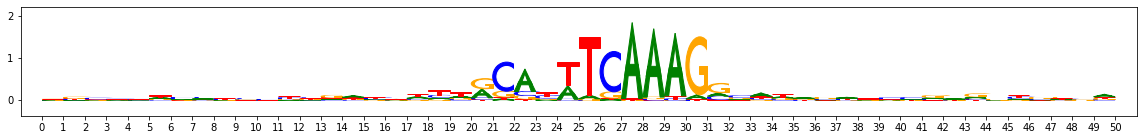

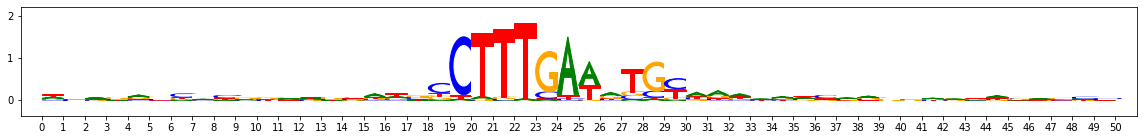

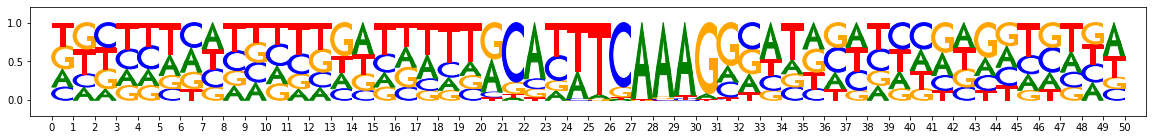

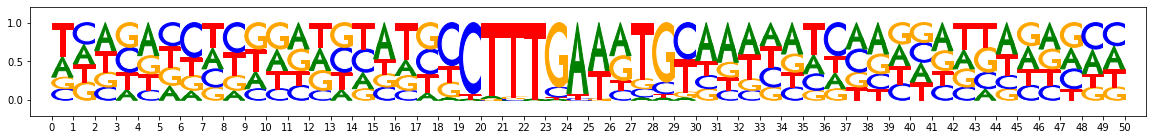

metacluster_0 pattern_4
total seqlets: 37
Hypothetical scores:


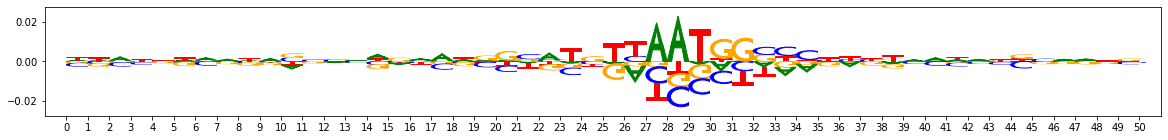

Actual importance scores:


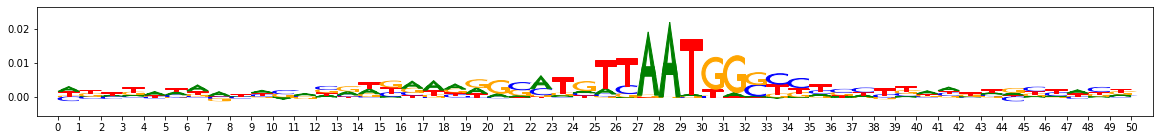

onehot, fwd and rev:


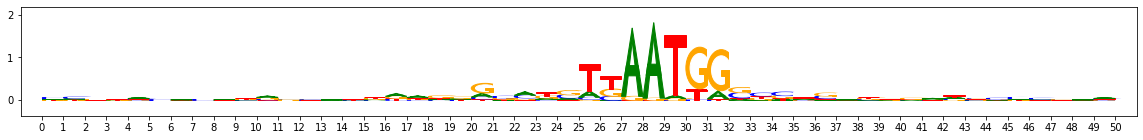

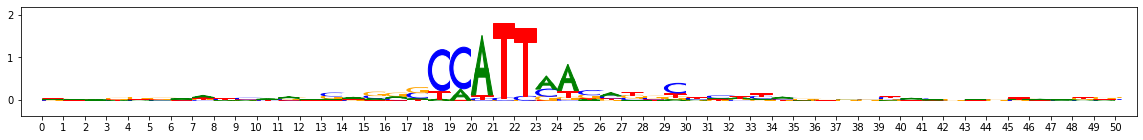

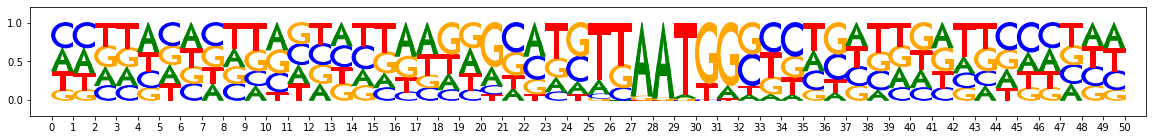

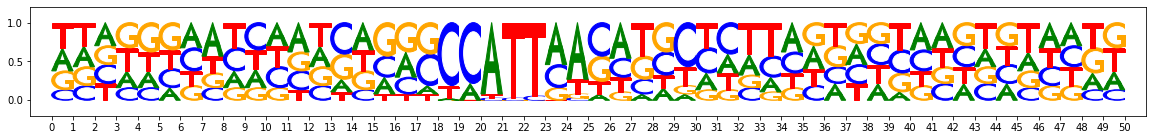

metacluster_0 pattern_5
total seqlets: 21
Hypothetical scores:


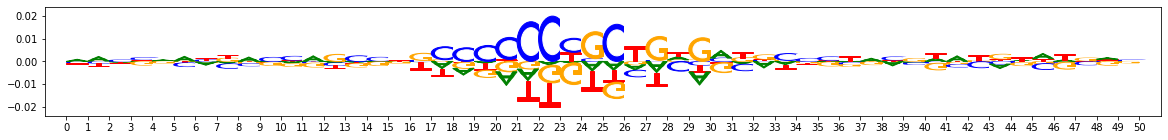

Actual importance scores:


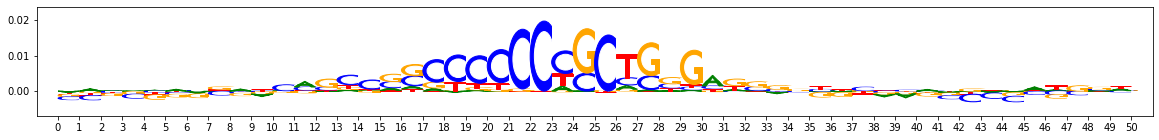

onehot, fwd and rev:


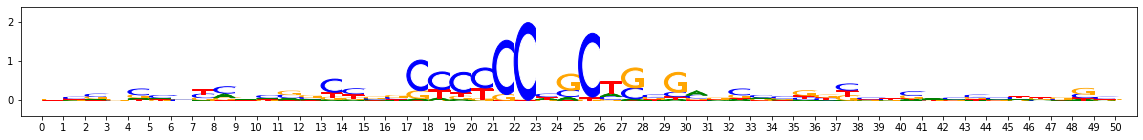

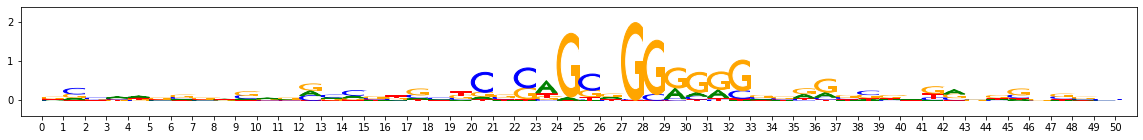

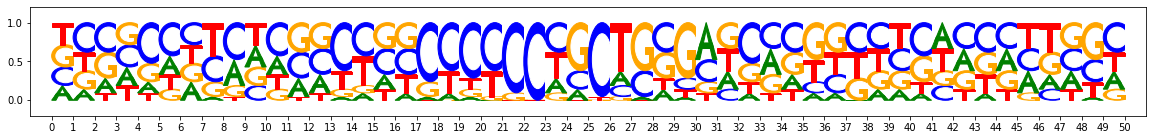

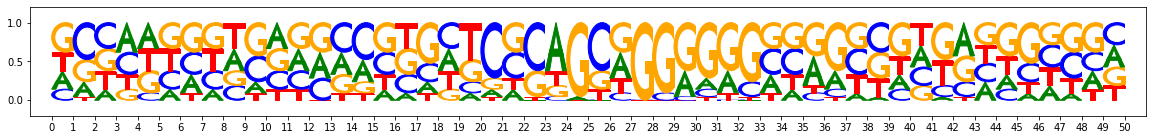

In [7]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5", "r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
        ##Plot the subclustering too, if available
        #if ("subclusters" in pattern):
        #    print("PLOTTING SUBCLUSTERS")
        #    subclusters = np.array(pattern["subclusters"])
        #    twod_embedding = np.array(pattern["twod_embedding"])
        #    plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
        #    plt.show()
        #    for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
        #        subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
        #        print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
        #        subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
        #        plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
        #        plt.show()
        #        viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
        #        viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
        #        viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()